# Importing libraries & Images

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import splitfolders

#(The following code need not be run again so it's commented out)
#splitfolders.ratio("data/", output="split-data/",
#                  seed = 42, ratio=(0.8, 0.15, 0.05))

In [3]:
#Renaming filenames

import os
directory = "split-data/train/"

'''
##debugging file access (getting comfortable with 'os' and file handling in general)

for folder in os.listdir(directory): #'listdir' returns a list of all files/directories in the specified
    print(" ")
    count = 0
    if not os.path.isdir(folder): #'isdir' returns a boolean value: True if the current object is a directory, False otherwise
                              #this is to combat 'listdir' listing hidden files (such as .DS_Store on MacOS), causing errors
        continue
        
    folder_path = os.path.join(directory, folder) #'join' concatenates the first/second argument (creating a new path)
    print(folder_path)
    for filename in os.listdir(folder_path):
        old_path = os.path.join(folder_path, filename)
        print(old_path)
        count+=1
        if count == 3:
            break
'''


##Actually renaming the files:
#(similarly this code need not be run again)
'''
for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder)
    if not os.path.isdir(folder_path):
        continue
        
    count=1
    for filename in os.listdir(folder_path):
        old_path = os.path.join(folder_path, filename)
        if not os.path.isfile(old_path):
            continue
        extension = os.path.splitext(filename)[1] #retrieves extension by splitting on the filename
        new_name = f"{folder}_{count:04d}{extension}"
        new_path = os.path.join(folder_path, new_name)
        
        os.rename(old_path, new_path)
        #print(f"Renamed {old_path} to {new_path}")
        count+=1
'''

'\nfor folder in os.listdir(directory):\n    folder_path = os.path.join(directory, folder)\n    if not os.path.isdir(folder_path):\n        continue\n        \n    count=1\n    for filename in os.listdir(folder_path):\n        old_path = os.path.join(folder_path, filename)\n        if not os.path.isfile(old_path):\n            continue\n        extension = os.path.splitext(filename)[1] #retrieves extension by splitting on the filename\n        new_name = f"{folder}_{count:04d}{extension}"\n        new_path = os.path.join(folder_path, new_name)\n        \n        os.rename(old_path, new_path)\n        #print(f"Renamed {old_path} to {new_path}")\n        count+=1\n'

# Data Preprocessing

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Understanding what happens under the hood

- **ImageDataGenerator**: Does not actually store any data, rather it stores **rules** for data preprocessing, like:
  - preprocessing settings (rescaling, normalization, etc.)
  - augmentation rules (what transformations to apply - these are specified in the call)
  - configuration parameters (e.g. seed)
  **It's like the *blueprint* for generating the augmented images**

- **flow_from_directory**: An **iterator** is created to *scan the directory* passed into 'ImageDataGenerator'
  - loads the images into batches (using the specified sizes) *during training*
  - applies the preprocessing/agumentation rules specified by the 'ImageDataGenerator'
  - returns a 'DirectoryIterator' object,  which yields tuples of (X,y) when iterated (X is a batch of images, y is a *one-hot-encoded* vector of class labels)
  - using 'next()' the iterator advances to the next batch

In [5]:
#applying transformations (not finalized)

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   shear_range = 0.1,
                                   rotation_range = 10,
                                   brightness_range = [0.8,1.2],
                                   horizontal_flip = True)

train_set = train_datagen.flow_from_directory(directory,
                                              target_size = (224,224),
                                              color_mode = "rgb",         # colored images
                                              class_mode = 'categorical', # multiple classes
                                              batch_size = 32,            # 32 images in each training batch
                                              shuffle = True,             # we don't want the model to memorize the order of the images
                                              seed = 42)                  # seed is added for reproducability

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_set = validation_datagen.flow_from_directory("split-data/val",
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='categorical',
                                                        shuffle=False)    # no need to shuffle the validation/test sets

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_set = test_datagen.flow_from_directory('split-data/test',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='categorical',
                                            shuffle=False)

Found 10414 images belonging to 14 classes.
Found 1947 images belonging to 14 classes.
Found 663 images belonging to 14 classes.


In [6]:
train_set.class_indices

{'Corn_Common_Rust': 0,
 'Corn_Gray_Leaf_Spot': 1,
 'Corn_Healthy': 2,
 'Corn_Northern_Leaf_Blight': 3,
 'Potato_Early_Blight': 4,
 'Potato_Healthy': 5,
 'Potato_Late_Blight': 6,
 'Rice_Brown_Spot': 7,
 'Rice_Healthy': 8,
 'Rice_Leaf_Blast': 9,
 'Rice_Neck_Blast': 10,
 'Wheat_Brown_Rust': 11,
 'Wheat_Healthy': 12,
 'Wheat_Yellow_Rust': 13}

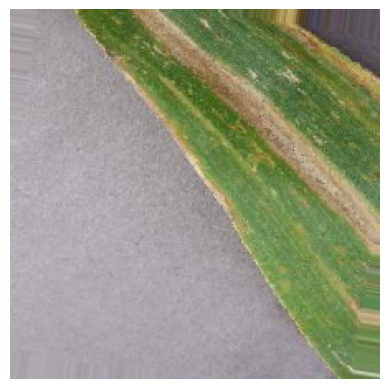

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label:  Corn_Northern_Leaf_Blight


In [7]:
images, labels = next(train_set)
# next() returns the 'next' batch of 32 images

plt.imshow(images[0])
plt.axis('off')
plt.show()

print(labels[0])
print("Label: ", list(train_set.class_indices.keys())[np.argmax(labels[0])]) #np.argmax returns the index of the largest value in the list
                                                                             #(which will be 1) which can be used to determine the class

Sanity check to ensure data augmentation works as expected and labels are correct

In [8]:
# checking for corrupt files
from PIL import Image
count = 0
for folder_name in os.listdir(directory):
    folder_path = os.path.join(directory, folder_name)
    if not os.path.isdir(folder_path):
        continue
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if not os.path.isdir(file_path):
            break
        try:
            im = Image.open(file_path)
            im.verify()
            im.close()
        except (IOError, OSError, Image.DecompressionBombError):
            print(f"Fail: {filename}")
            count+=1

print(count, "corrputed files")

0 corrputed files


No corrupt files

In [9]:
# exploring / handling class imbalances
for folder_name in os.listdir(directory):
    count = 0
    folder_path = os.path.join(directory, folder_name)
    if not os.path.isdir(folder_path):
        continue
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        count+=1
    print(folder_name, ": ", count)

Potato_Late_Blight :  800
Corn_Healthy :  929
Wheat_Healthy :  892
Corn_Common_Rust :  954
Rice_Neck_Blast :  800
Potato_Early_Blight :  800
Rice_Leaf_Blast :  781
Wheat_Yellow_Rust :  740
Potato_Healthy :  121
Rice_Healthy :  1191
Corn_Gray_Leaf_Spot :  411
Wheat_Brown_Rust :  721
Corn_Northern_Leaf_Blight :  788
Rice_Brown_Spot :  490


In [10]:
#we can aim to have 700-1000 images in each class

'''
Classes to be oversampled:
- Potato Healthy: 121
- Corn Gray Leaf Spot: 410
- Rice Brown Spot: 490

'Rice Healthy' may be undersampled to 900-1000 observations
'''

"\nClasses to be oversampled:\n- Potato Healthy: 121\n- Corn Gray Leaf Spot: 410\n- Rice Brown Spot: 490\n\n'Rice Healthy' may be undersampled to 900-1000 observations\n"

## Handling the class imbalance

In [11]:
import random

dataset_dir = "split-data/train"
target_size = 700

data = []

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    
    image_files = [
        os.path.abspath(os.path.join(class_path, fname))
        for fname in os.listdir(class_path)
        if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]
    
    if len(image_files) < target_size:
        multiplier = target_size // len(image_files)
        remainder = target_size % len(image_files)
        oversampled = image_files * multiplier + random.sample(image_files, remainder)
    else:
        oversampled = image_files

    for img_path in oversampled:
        data.append((img_path, class_name))

df = pd.DataFrame(data, columns=["filename", "class"])
df["filename"].apply(os.path.exists).value_counts()

filename
True    11493
Name: count, dtype: int64

In [12]:
df["class"].value_counts().sort_index()

class
Corn_Common_Rust              953
Corn_Gray_Leaf_Spot           700
Corn_Healthy                  929
Corn_Northern_Leaf_Blight     788
Potato_Early_Blight           800
Potato_Healthy                700
Potato_Late_Blight            800
Rice_Brown_Spot               700
Rice_Healthy                 1190
Rice_Leaf_Blast               781
Rice_Neck_Blast               800
Wheat_Brown_Rust              721
Wheat_Healthy                 892
Wheat_Yellow_Rust             739
Name: count, dtype: int64

In [13]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   shear_range = 0.1,
                                   rotation_range = 10,
                                   brightness_range = [0.8,1.2],
                                   horizontal_flip = True)

train_set = train_datagen.flow_from_dataframe(dataframe=df,
                                              x_col = "filename",
                                              y_col = "class",
                                              target_size = (224, 224),
                                              batch_size = 32,
                                              class_mode = "categorical",
                                              shuffle = True,
                                              seed = 42,
                                              directory = None)


validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
validation_set = validation_datagen.flow_from_directory("split-data/val",
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='categorical',
                                                        shuffle=False)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_set = test_datagen.flow_from_directory('split-data/test',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='categorical',
                                            shuffle=False)

Found 11493 validated image filenames belonging to 14 classes.
Found 1947 images belonging to 14 classes.
Found 663 images belonging to 14 classes.


# Model Development

## CNN from Scratch

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(14, activation='softmax')
])

/Users/kareem/Desktop/DS/SDS/CPs/SDS-CP028-smart-leaf/submissions/team-members/david-boules/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training takes approx. 30 minutes for 10 epochs
history = model.fit(train_set,
                    validation_data=validation_set,
                    epochs=10)

/Users/kareem/Desktop/DS/SDS/CPs/SDS-CP028-smart-leaf/submissions/team-members/david-boules/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 199s 551ms/step - accuracy: 0.5811 - loss: 1.4981 - val_accuracy: 0.8408 - val_loss: 0.3924
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 197s 546ms/step - accuracy: 0.8226 - loss: 0.4203 - val_accuracy: 0.8146 - val_loss: 0.4663
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 186s 514ms/step - accuracy: 0.8385 - loss: 0.3865 - val_accuracy: 0.8500 - val_loss: 0.3734
Epoch 4/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 195s 542ms/step - accuracy: 0.8602 - loss: 0.3287 - val_accuracy: 0.8120 - val_loss: 0.4731
Epoch 5/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 186s 515ms/step - accuracy: 0.8615 - loss: 0.3329 - val_accuracy: 0.8428 - val_loss: 0.3855
Epoch 6/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 192s 532ms/step - accuracy: 0.8648 - loss: 0.3375 - val_accuracy: 0.8511 - val_loss: 0.3628
Epoch 7/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 191s 529ms/step - accuracy: 0.8860 - loss: 0.2778 - val_accuracy: 0.8459 - val_loss: 0.3960
Epoch 8/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 194s 539ms/step - accuracy: 0.8913 -

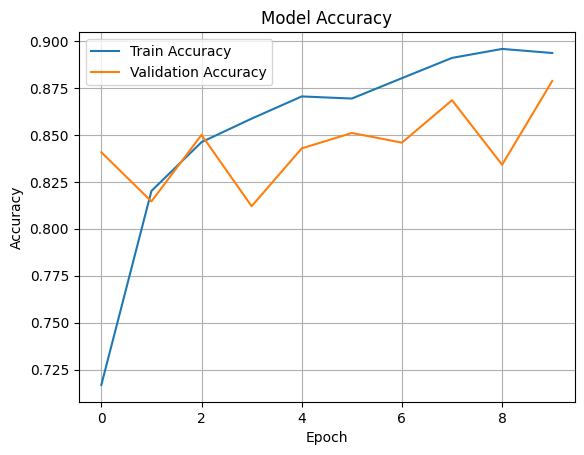

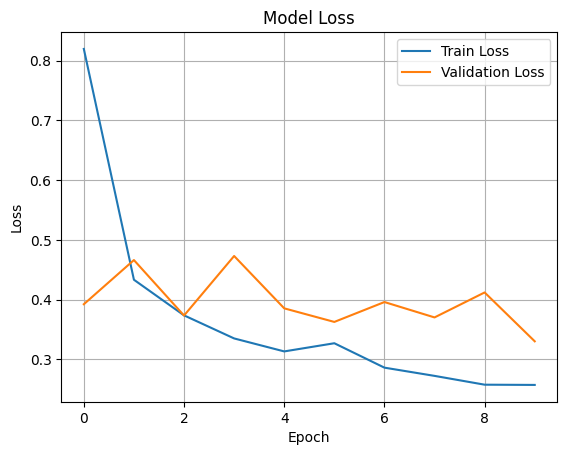

In [16]:
# Model Evaluation (graphs, confusion matrix, etc.)
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
from sklearn.metrics import classification_report
import numpy as np

# Predict class probabilities and get argmax
y_pred_probs = model.predict(test_set)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_set.classes
class_labels = list(test_set.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step
                           precision    recall  f1-score   support

         Corn_Common_Rust       1.00      1.00      1.00        61
      Corn_Gray_Leaf_Spot       0.77      0.89      0.83        27
             Corn_Healthy       0.98      1.00      0.99        59
Corn_Northern_Leaf_Blight       0.93      0.80      0.86        50
      Potato_Early_Blight       0.96      0.96      0.96        50
           Potato_Healthy       0.75      1.00      0.86         9
       Potato_Late_Blight       0.96      0.90      0.93        50
          Rice_Brown_Spot       0.81      0.53      0.64        32
             Rice_Healthy       0.63      0.95      0.76        75
          Rice_Leaf_Blast       0.67      0.32      0.43        50
          Rice_Neck_Blast       1.00      1.00      1.00        50
         Wheat_Brown_Rust       0.92      1.00      0.96        46
            Wheat_Healthy       1.00      0.96      0.98        57
        Wheat_Yellow

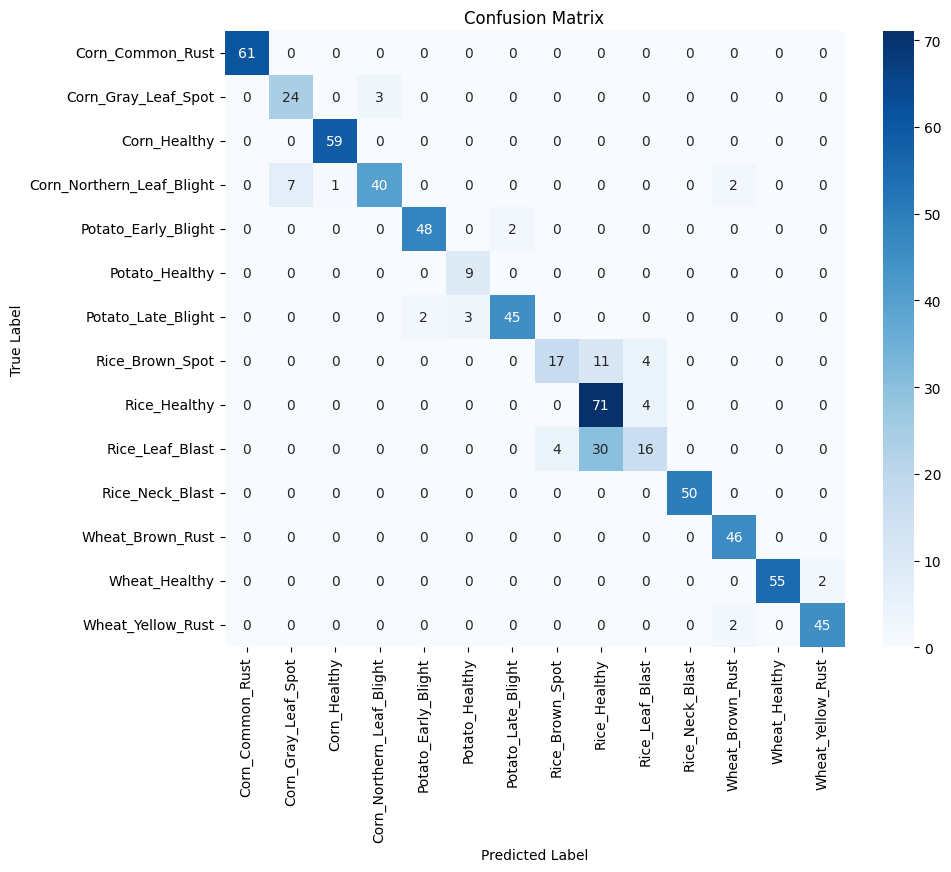

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [20]:
test_loss, test_acc = model.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.3f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9128 - loss: 0.2711
Test Accuracy: 0.884


In [21]:
# Exporting model
model.save("model.keras")

## Transfer Learning with EfficientNetB0


In [22]:
# Import necessary libraries
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet',
                include_top=False,
                input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(14, activation='softmax')(x)  # 14 classes output

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6)

# Display model summary
# model.summary()

Initial training phase with frozen base model...
Epoch 1/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 140s 381ms/step - accuracy: 0.0946 - loss: 2.6543 - val_accuracy: 0.1145 - val_loss: 2.6257 - learning_rate: 0.0010
Epoch 2/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 131s 364ms/step - accuracy: 0.1018 - loss: 2.6312 - val_accuracy: 0.1145 - val_loss: 2.6107 - learning_rate: 0.0010
Epoch 3/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 134s 371ms/step - accuracy: 0.1025 - loss: 2.6293 - val_accuracy: 0.1145 - val_loss: 2.6099 - learning_rate: 0.0010
Epoch 4/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 130s 361ms/step - accuracy: 0.1011 - loss: 2.6286 - val_accuracy: 0.1145 - val_loss: 2.6099 - learning_rate: 0.0010
Epoch 5/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 130s 360ms/step - accuracy: 0.1009 - loss: 2.6297 - val_accuracy: 0.1145 - val_loss: 2.6084 - learning_rate: 0.0010


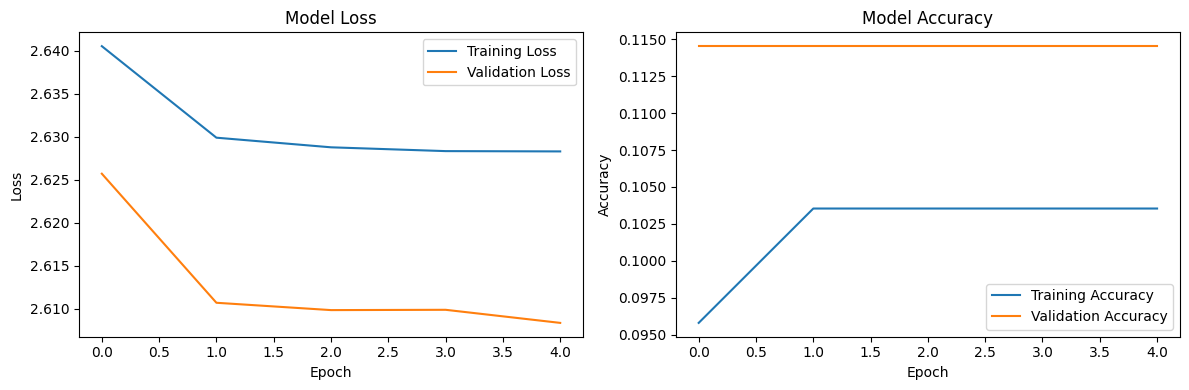

In [23]:
# Initial training phase
print("Initial training phase with frozen base model...")
history = model.fit(
    train_set,
    validation_data=validation_set,
    epochs=5,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Fine-tuning phase with unfrozen base model layers...
Epoch 1/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 585s 2s/step - accuracy: 0.5903 - loss: 1.3225 - val_accuracy: 0.1356 - val_loss: 2.7670 - learning_rate: 1.0000e-04
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 569s 2s/step - accuracy: 0.9036 - loss: 0.2559 - val_accuracy: 0.5999 - val_loss: 1.1458 - learning_rate: 1.0000e-04
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 570s 2s/step - accuracy: 0.9325 - loss: 0.1866 - val_accuracy: 0.4566 - val_loss: 1.6769 - learning_rate: 1.0000e-04
Epoch 4/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 614s 2s/step - accuracy: 0.9453 - loss: 0.1489 - val_accuracy: 0.6097 - val_loss: 1.2062 - learning_rate: 1.0000e-04
Epoch 5/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 596s 2s/step - accuracy: 0.9601 - loss: 0.1137 - val_accuracy: 0.8896 - val_loss: 0.3021 - learning_rate: 2.0000e-05
Epoch 6/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 587s 2s/step - accuracy: 0.9617 - loss: 0.1052 - val_accuracy: 0.8002 - val_loss: 0.5717 - learning_rate: 2.0000e-05
Epoc

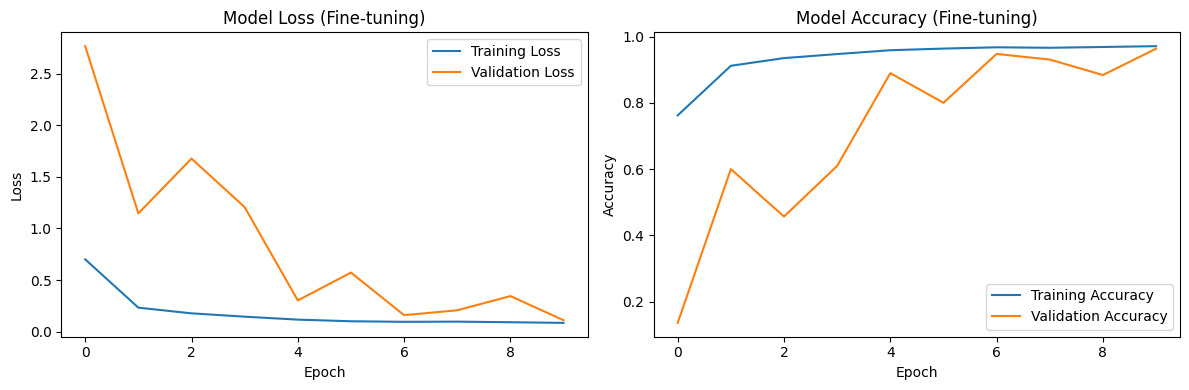

In [24]:
# Fine-tuning phase
print("\nFine-tuning phase with unfrozen base model layers...")

# Unfreeze the base model
base_model.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Train with unfrozen layers
history_fine = model.fit(
    train_set,
    validation_data=validation_set,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

# Plot fine-tuning history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Fine-tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Fine-tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Evaluate on test set
print("\nEvaluating model on test set...")
test_loss, test_accuracy = model.evaluate(test_set)
print(f"\nTest accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Save the model
model.save("efficientnetb0.keras")
print("\nModel saved as 'efficientnetb0.keras'")



Evaluating model on test set...
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 318ms/step - accuracy: 0.9649 - loss: 0.0949

Test accuracy: 0.9593
Test loss: 0.1185

Model saved as 'efficientnetb0.keras'


In [26]:
from sklearn.metrics import classification_report
import numpy as np

y_pred_probs = model.predict(test_set)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_set.classes
class_labels = list(test_set.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 356ms/step
                           precision    recall  f1-score   support

         Corn_Common_Rust       1.00      1.00      1.00        61
      Corn_Gray_Leaf_Spot       1.00      0.85      0.92        27
             Corn_Healthy       1.00      1.00      1.00        59
Corn_Northern_Leaf_Blight       0.93      1.00      0.96        50
      Potato_Early_Blight       1.00      1.00      1.00        50
           Potato_Healthy       1.00      1.00      1.00         9
       Potato_Late_Blight       1.00      1.00      1.00        50
          Rice_Brown_Spot       0.91      0.66      0.76        32
             Rice_Healthy       0.86      0.96      0.91        75
          Rice_Leaf_Blast       0.82      0.82      0.82        50
          Rice_Neck_Blast       1.00      1.00      1.00        50
         Wheat_Brown_Rust       1.00      1.00      1.00        46
            Wheat_Healthy       1.00      1.00      1.00        57
        Wheat_Yellow